In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely import wkt
from shapely.ops import unary_union

import io
import base64
from IPython.display import HTML
import matplotlib.animation as animation

# 活动驻留分布

In [4]:
# 导入数据
path = 'D:/317研究组/4 居住自选择/data/relocation_sample_stay.csv'
sample_stay = pd.read_csv(path)

sample_stay['stime'] = pd.to_datetime(sample_stay['stime'],format='%Y-%m-%d %H:%M:%S')
sample_stay['etime'] = pd.to_datetime(sample_stay['etime'],format='%Y-%m-%d %H:%M:%S')

# 增加一列指示月份
sample_stay['yearmonth'] = np.floor(sample_stay['date']/100)*100+1

# 改名
sample_stay.rename(columns={'chinese':'lambda','math':'phi'},inplace=True)
sample_stay['lambda'] = sample_stay['lambda']*10-5
sample_stay['phi'] = sample_stay['phi']*10-5

sample_stay.head()

,who,date,stime,etime,poi_id,lambda,phi,yearmonth
0,509,20191228,2019-12-28 08:09:56,2019-12-28 08:40:22,11,114.113935,22.606130,20191201.0
1,509,20200502,2020-05-02 16:05:32,2020-05-02 16:54:03,8,114.081120,22.544308,20200501.0
2,509,20190817,2019-08-17 00:02:56,2019-08-17 08:07:10,2,113.891201,22.586069,20190801.0
3,509,20190828,2019-08-28 05:40:55,2019-08-28 08:35:05,2,113.891201,22.586069,20190801.0
4,509,20190801,2019-08-01 19:20:31,2019-08-01 19:20:31,2,113.891201,22.586069,20190801.0


In [5]:
#按照year_month和poi_id分组，统计每个poi_id出现的次数
sample_stay_count =sample_stay.groupby(['who','yearmonth','poi_id']).agg(stay_count=('poi_id','count'),
                                                                  mean_lambda=('lambda','mean'),
                                                                  mean_phi=('phi','mean')).reset_index()
sample_stay_count.head()

,who,yearmonth,poi_id,stay_count,mean_lambda,mean_phi
0,509,20190101.0,0,14,113.917963,22.531129
1,509,20190101.0,1,20,113.873627,22.586188
2,509,20190101.0,2,1,113.919876,22.546462
3,509,20190101.0,3,1,113.878230,22.580340
4,509,20190101.0,6,1,114.170399,22.627131


In [8]:
# 为df137_stay_count构建gpd对象
poi_geometry = [Point(xy) for xy in zip(sample_stay_count['mean_lambda'],sample_stay_count['mean_phi'])]
crs = {'init':'epsg:4326'}
sample_stay_gpd = gpd.GeoDataFrame(sample_stay_count,crs=crs,geometry=poi_geometry)

C:\Users\huangnx\AppData\Roaming\Python\Python39\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [46]:
# 导入家数据
path1 ='D:/317研究组/4 居住自选择/data/sample_data/who137_home.csv'
sample_home = pd.read_csv(path1)

city_grid = pd.read_csv('D:/317研究组/4 居住自选择/data/ss_city_grid/grid/ss_city_grid.csv')
sample_home  = pd.merge(sample_home,city_grid[['fnid','wkt']],on='fnid',how='left')
sample_home

,who,date,fnid,chess_x,chess_y,home_fre,home_time,od_num,max_fre,max_time,group_id,avg_fre,wkt
0,137,20190701,10425.0,72.0,29.0,16.0,592993.0,33.0,16,592993,0,21.500000,"MULTIPOLYGON (((113.92486387 22.51166277,113.9..."
1,137,20190801,11139.0,72.0,31.0,27.0,755192.0,44.0,27,755192,0,21.500000,"MULTIPOLYGON (((113.92486387 22.51609468,113.9..."
2,137,20190901,32607.0,120.0,91.0,21.0,507867.0,21.0,21,522643,1,32.333333,"MULTIPOLYGON (((114.042 22.64905213,114.044440..."
3,137,20191001,32249.0,119.0,90.0,25.0,424476.0,25.0,25,424476,1,32.333333,"MULTIPOLYGON (((114.03955966 22.64683617,114.0..."
4,137,20191101,32249.0,119.0,90.0,27.0,579394.0,23.0,44,860174,1,39.500000,"MULTIPOLYGON (((114.03955966 22.64683617,114.0..."
5,137,20191201,32249.0,119.0,90.0,51.0,1050012.0,45.0,51,1050012,1,32.333333,"MULTIPOLYGON (((114.03955966 22.64683617,114.0..."
6,137,20200501,45719.0,23.0,128.0,35.0,787488.0,36.0,35,787488,1,39.500000,"MULTIPOLYGON (((113.8052874 22.73104255,113.80..."


In [47]:
# 转化为gpd对象
sample_home['wkt'] = sample_home['wkt'].apply(wkt.loads)
sample_home['wkt_centroid'] = [x.centroid for x in sample_home['wkt']]
crs = {'init':'epsg:4326'}
sample_home_gpd = gpd.GeoDataFrame(sample_home,crs=crs,geometry=sample_home.wkt_centroid)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\huangnx\AppData\Roaming\Python\Python39\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Axes: >

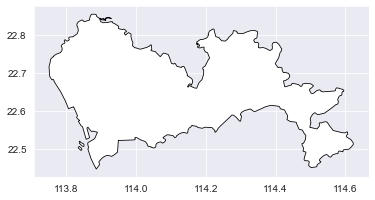

In [17]:
# 导入深圳地图
file_name ="D:/317研究组/4 居住自选择/data/shenzhen_polygon/Shenzhen_polygon.shp"
sz_poly = gpd.read_file(file_name)

sz_poly.plot(fc='white',ec='black',linewidth=.8)

<AxesSubplot:>

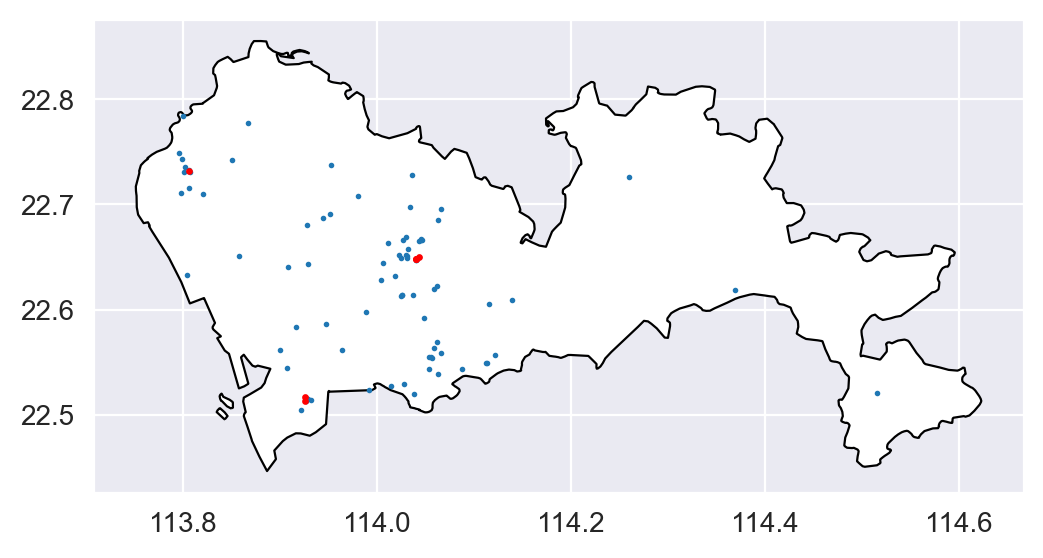

In [48]:
fig,ax = plt.subplots(dpi=200)
sz_poly.plot(ax=ax,fc='white',ec='black',linewidth=.8)
sample_stay_gpd.plot(ax=ax,markersize=1)
sample_home_gpd.plot(ax=ax, c='red', markersize=2)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>


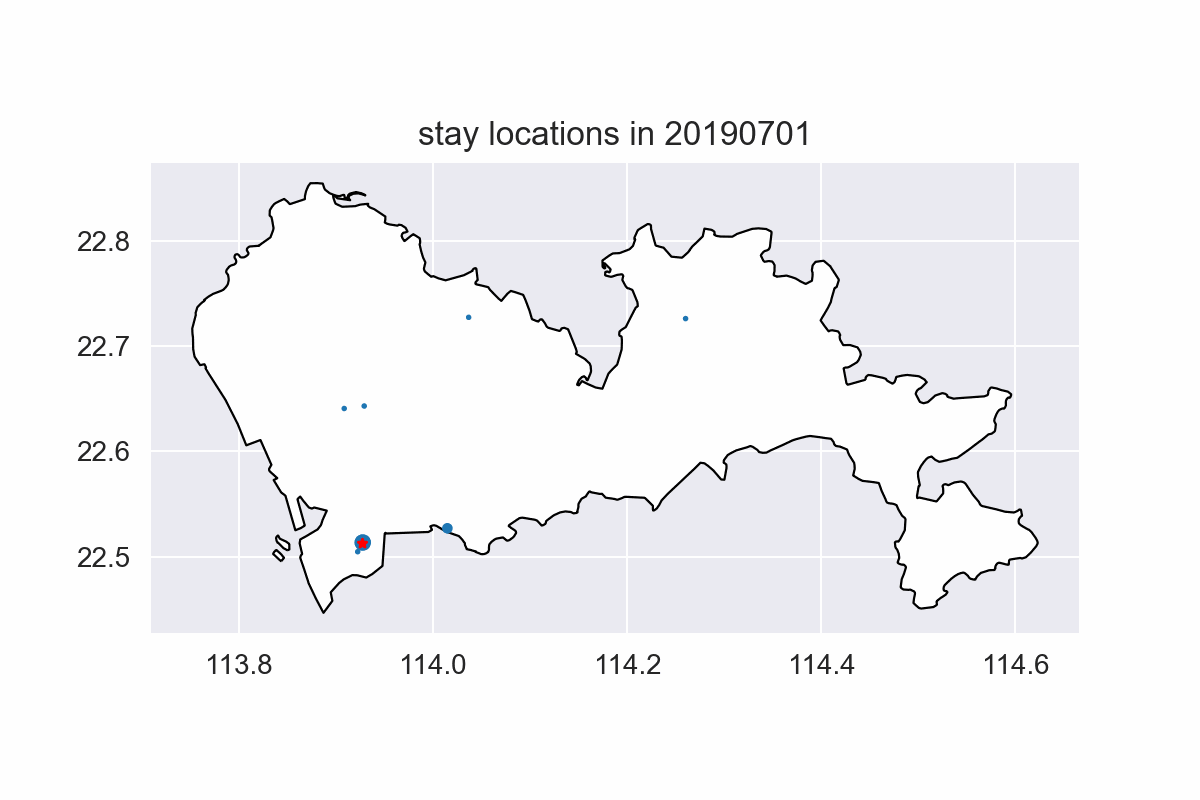

In [73]:
# 以动图的形式，分date画出df504_gpd中的POINT，映射在sz_poly上
fig,ax = plt.subplots(dpi=200)

# 选择df504_gpd中的date列，去重，排序，得到时间索引，只选择date小于20200101的数据
date_index = sample_home_gpd[sample_home_gpd['date']<20200101]['date'].unique()
date_index.sort()

# FuncAnimation：通过反复调用同一更新函数来制作动画
def animate_graph(t):
    ax.clear()
    ax.set_title('stay locations in '+str(date_index[t]))

    stay_data = sample_stay_gpd[sample_stay_gpd['yearmonth']==date_index[t]]
    home_data = sample_home_gpd[sample_home_gpd['date']==date_index[t]]

    sz_poly.plot(ax=ax,fc='white',ec='black',linewidth=.8)
    # 画出stay_data，点的大小由stay_count决定
    stay_data.plot(ax=ax, markersize=stay_data['stay_count'])
    home_data.plot(ax=ax, c='red', marker='*', markersize=10)
    #ax.set_xlim(bounds[0],bounds[2])
    #ax.set_ylim(bounds[1],bounds[3])
    plt.show()

t = [i for i in range(len(date_index))]
ani = animation.FuncAnimation(fig,animate_graph,t, interval=1000)

plt.close()
save_path = 'D:/317研究组/4 居住自选择/img/stay137_animation.gif'
ani.save(save_path,writer='pillow')
video = io.open(save_path,'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

In [40]:
who_list = sample_stay_gpd['who'].unique()
one_stay_gpd = sample_stay_gpd[sample_stay_gpd['who']==who_list[9]]

In [15]:
one_stay_gpd

,who,yearmonth,poi_id,stay_count,mean_lambda,mean_phi,geometry
0,509,20190101.0,0,14,113.917963,22.531129,POINT (113.91796 22.53113)
1,509,20190101.0,1,20,113.873627,22.586188,POINT (113.87363 22.58619)
2,509,20190101.0,2,1,113.919876,22.546462,POINT (113.91988 22.54646)
3,509,20190101.0,3,1,113.878230,22.580340,POINT (113.87823 22.58034)
4,509,20190101.0,6,1,114.170399,22.627131,POINT (114.17040 22.62713)
...,...,...,...,...,...,...,...
187,509,20220501.0,4,4,113.906250,22.788391,POINT (113.90625 22.78839)
188,509,20220501.0,5,1,113.944016,22.784958,POINT (113.94402 22.78496)
189,509,20220501.0,6,4,113.894234,22.779465,POINT (113.89423 22.77946)
190,509,20220501.0,7,1,113.895950,22.794571,POINT (113.89595 22.79457)


IndexError: index 23 is out of bounds for axis 0 with size 23

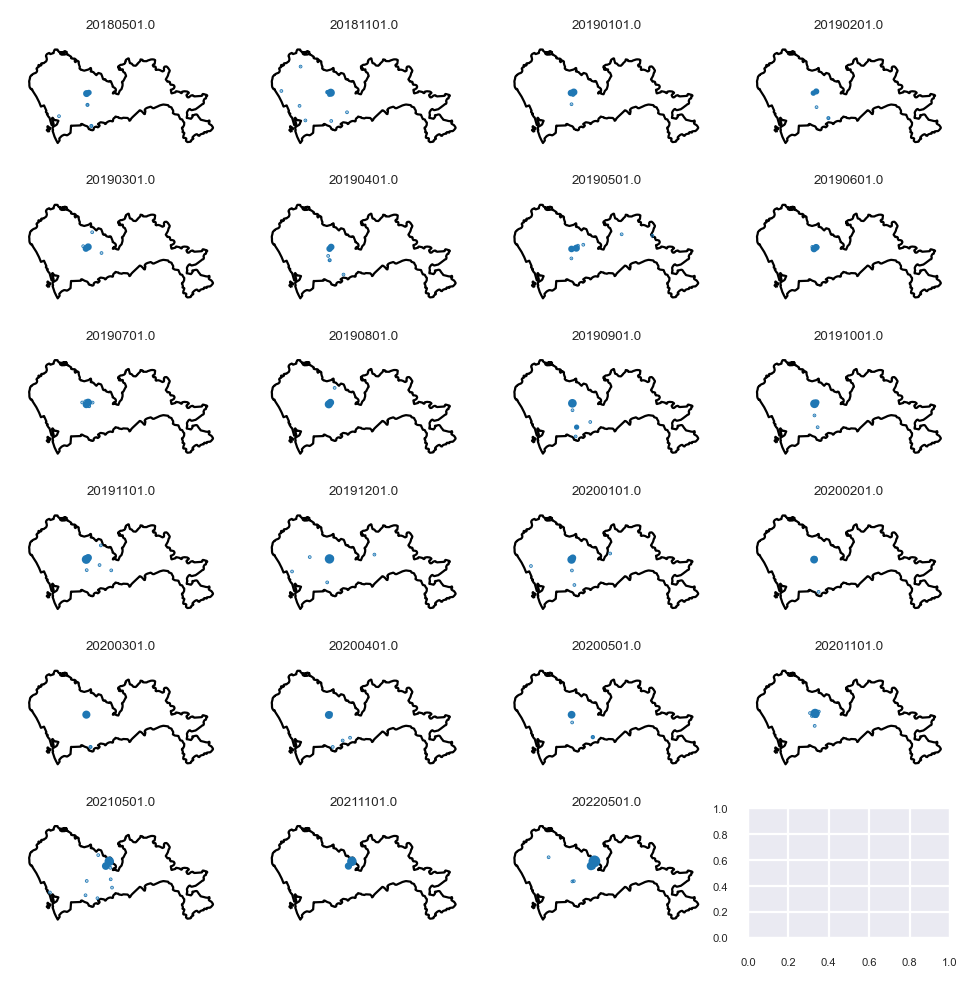

In [41]:
# 以分图的形式绘制每个月的活动点
m = 6; n=4 #定义子图的行数和列数
fig,ax = plt.subplots(m,n,figsize= (6,6), dpi=200)
# 设置较小的字体
plt.rcParams.update({'font.size': 4})
date_index =one_stay_gpd['yearmonth'].unique()
date_index.sort()
for i in range(m):
    for j in range(n):
        t = i*n+j
        ax[i,j].set_title(str(date_index[t]))
        stay_data = one_stay_gpd[one_stay_gpd['yearmonth']==date_index[t]]
        #home_data = sample_home_gpd[sample_home_gpd['date']==date_index[t]]
        sz_poly.plot(ax=ax[i,j],fc='white',ec='black',linewidth=.8)
        # 画出stay_data，点的大小由stay_count决定
        stay_data.plot(ax=ax[i,j], markersize=stay_data['stay_count']/10)
        # 设置坐标轴不可见
        ax[i,j].set_axis_off()
        #home_data.plot(ax=ax[i,j], c='red', marker='*', markersize=10)
    #ax.set_xlim(bounds[0],bounds[2])
    #ax.set_ylim(bounds[1],bounds[3])
plt.show()

In [17]:
date_index

array([20190101., 20190201., 20190301., 20190401., 20190501., 20190601.,
       20190701., 20190801., 20190901., 20191001., 20191101., 20191201.,
       20200101., 20200201., 20200301., 20200401., 20200501., 20201101.,
       20210501., 20211101., 20220501.])

In [30]:
str(date_index[17])

'20200501'

In [25]:
t

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

# 出行网络

In [2]:
path2 = 'D:/317研究组/4 居住自选择/data/relocation_sample_move.csv'
sample_move = pd.read_csv(path2)

sample_move['stime'] = pd.to_datetime(sample_move['stime'],format='%Y-%m-%d %H:%M:%S')
sample_move['etime'] = pd.to_datetime(sample_move['etime'],format='%Y-%m-%d %H:%M:%S')

# 增加一列指示月份
sample_move['yearmonth'] = np.floor(sample_move['date']/100)*100+1

# 改名
sample_move.rename(columns={'chinese':'lambda_o','math':'phi_o','english':'lambda_d','geography':'phi_d'},inplace=True)
sample_move['lambda_o'] = sample_move['lambda_o']*10-5
sample_move['phi_o'] = sample_move['phi_o']*10-5
sample_move['lambda_d'] = sample_move['lambda_d']*10-5
sample_move['phi_d'] = sample_move['phi_d']*10-5

sample_move.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5038 entries, 0 to 5037
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   who        5038 non-null   int64         
 1   stime      5038 non-null   datetime64[ns]
 2   etime      5038 non-null   datetime64[ns]
 3   date       5038 non-null   int64         
 4   lambda_o   4735 non-null   float64       
 5   phi_o      4735 non-null   float64       
 6   lambda_d   4726 non-null   float64       
 7   phi_d      4726 non-null   float64       
 8   yearmonth  5038 non-null   float64       
dtypes: datetime64[ns](2), float64(5), int64(2)
memory usage: 354.4 KB


In [3]:
sample_move.head()

,who,stime,etime,date,lambda_o,phi_o,lambda_d,phi_d,yearmonth
0,509,2019-05-20 08:22:17,2019-05-20 08:55:06,20190520,113.872923,22.585091,113.919358,22.531706,20190501.0
1,1315,2019-08-11 11:46:04,2019-08-11 12:22:30,20190811,113.828961,22.639240,114.114630,22.548777,20190801.0
2,1315,2019-08-11 19:18:23,2019-08-11 19:55:23,20190811,114.114630,22.548777,113.828961,22.639240,20190801.0
3,3861,2018-11-22 17:45:43,2018-11-22 17:53:40,20181122,114.114953,22.542553,114.039123,22.554560,20181101.0
4,1731,2019-01-30 07:55:04,2019-01-30 07:58:36,20190130,114.032822,22.651286,114.046950,22.674011,20190101.0


## 可视化每日出行距离

In [75]:
# 按照date分组，统计每日出行距离r
sample_move_distance = sample_move.groupby(['date']).agg(sum_r=('r','sum')).reset_index()

In [82]:
xticks = sample_move_distance['date'].unique()
xticks.sort()
xticks = xticks[::10]
xticks

array([20190708, 20190805, 20190901, 20190913, 20190924, 20191017,
       20191029, 20191109, 20191119, 20191129, 20191209, 20191220,
       20191230, 20200526], dtype=int64)

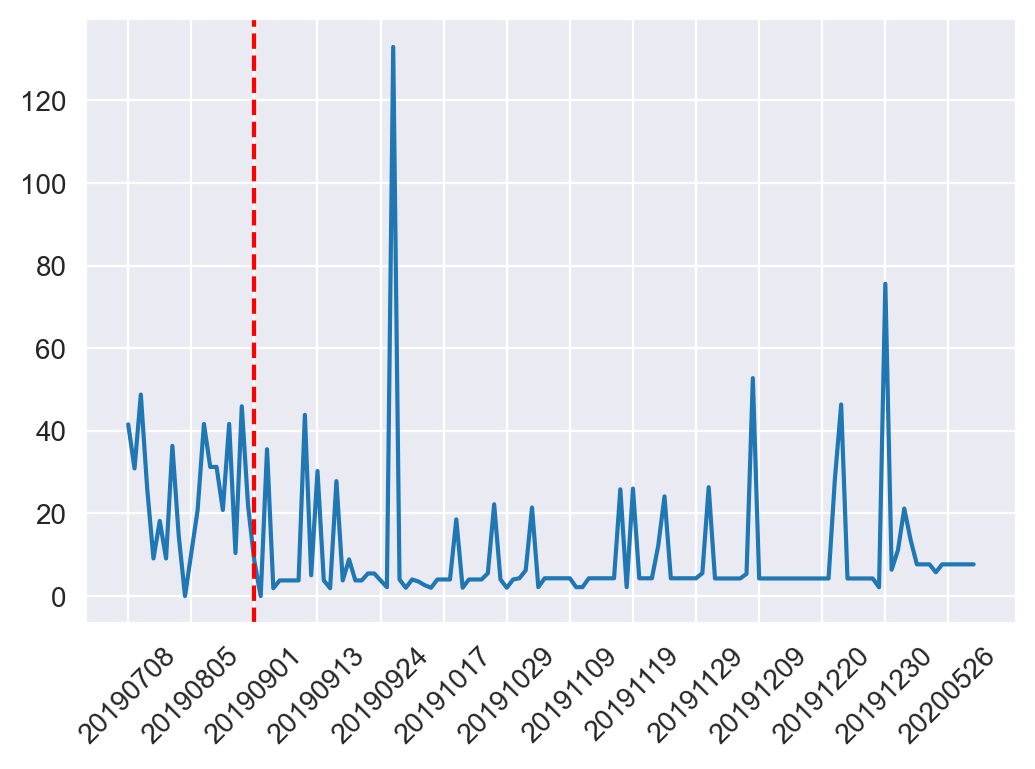

In [86]:
# 以date为横坐标，sum_r为纵坐标，画出每日出行距离
fig,ax = plt.subplots(dpi=200)
ax.plot(sample_move_distance['sum_r']/1000)

# 设置xticks，标签为date，每隔10个标签显示一个
ax.set_xticks(np.arange(0,len(sample_move_distance),10),xticks,rotation=45)
# 在date=20190901处画一条竖线
ax.axvline(x=sample_move_distance[sample_move_distance['date']==20190901].index[0],c='red',ls='--')

## 可视化出行网络


In [58]:
#按照year_month和poi_id分组，统计每个poi_id出现的次数
sample_move_count =sample_move.groupby(['yearmonth','poi_id_o','poi_id_d']).agg(stay_count=('poi_id_o','count'),
                                                                  mean_lambda_o=('lambda_o','mean'),
                                                                  mean_phi_o=('phi_o','mean'),
                                                                  mean_lambda_d=('lambda_d','mean'),
                                                                  mean_phi_d=('phi_d','mean'),).reset_index()
sample_move_count.head()

,yearmonth,poi_id_o,poi_id_d,stay_count,mean_lambda_o,mean_phi_o,mean_lambda_d,mean_phi_d
0,20190701.0,0,1,6,113.927294,22.513330,114.014562,22.526868
1,20190701.0,0,4,1,113.927294,22.513330,113.908254,22.640907
2,20190701.0,0,5,1,113.927294,22.513330,114.036468,22.727689
3,20190701.0,1,0,3,114.014562,22.526868,113.927294,22.513330
4,20190701.0,1,7,1,114.014562,22.526868,113.932626,22.514244


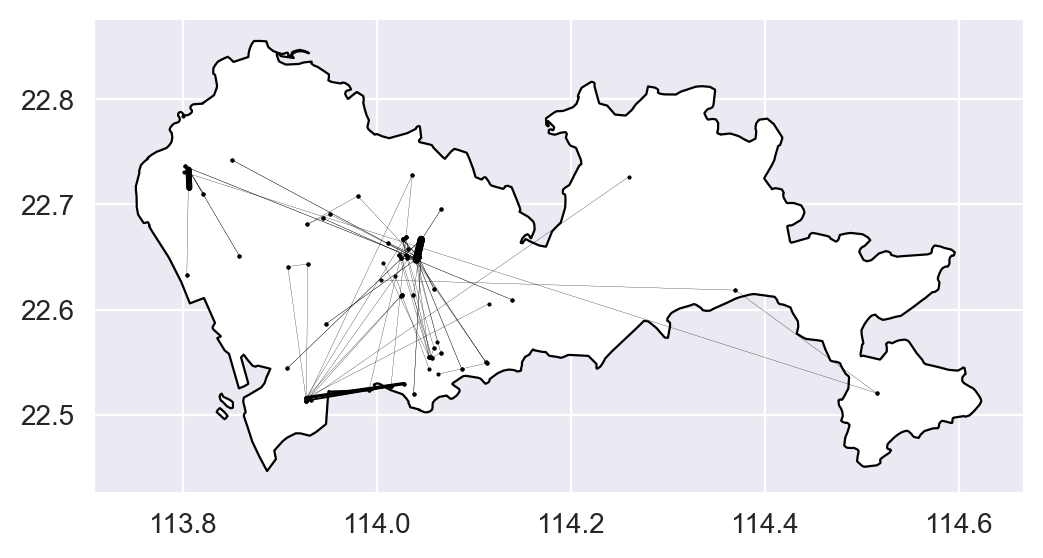

In [70]:
# 以df137_move的(lambda_o, phi_o)为起点经纬度，(lambda_d, phi_d)为终点经纬度，在sz_poly上画出出行网络
fig,ax = plt.subplots(dpi=200)
sz_poly.plot(ax=ax,fc='white',ec='black',linewidth=.8)
# 绘制sample_move_count中每行的od连线，起点坐标为(lambda_o, phi_o)，终点坐标为(lambda_d, phi_d)
for i in range(len(sample_move_count)):
    x = [sample_move_count['mean_lambda_o'][i],sample_move_count['mean_lambda_d'][i]]
    y = [sample_move_count['mean_phi_o'][i],sample_move_count['mean_phi_d'][i]]
    ax.plot(x,y,c='black', marker = 'o', markersize=.5, linewidth=sample_move_count['stay_count'][i]/10)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>


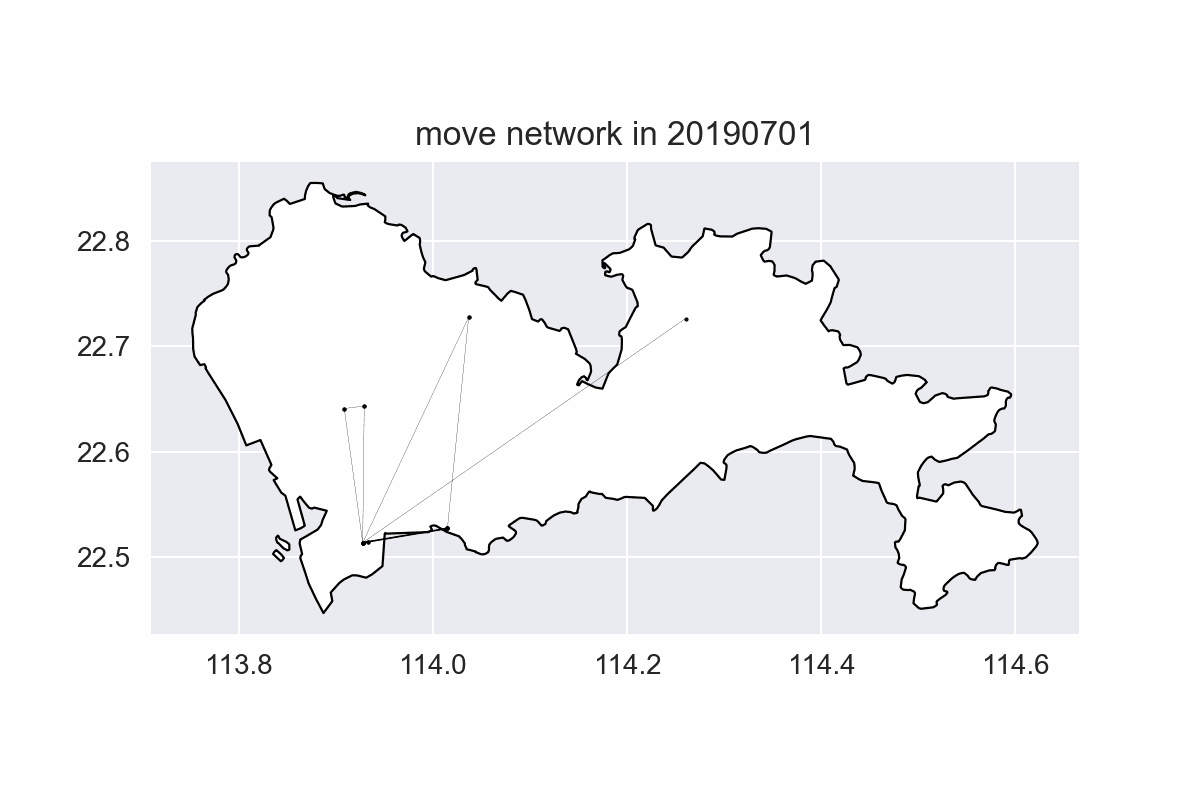

In [74]:
# 以动图的形式，分date画出df504_gpd中的POINT，映射在sz_poly上
fig,ax = plt.subplots(dpi=200)

# FuncAnimation：通过反复调用同一更新函数来制作动画
def animate_graph(t):
    ax.clear()
    ax.set_title('move network in '+str(date_index[t]))

    move_data = sample_move_count[sample_move_count['yearmonth']==date_index[t]].reset_index(drop=True)
    home_data = sample_home_gpd[sample_home_gpd['date']==date_index[t]]

    sz_poly.plot(ax=ax,fc='white',ec='black',linewidth=.8)
    # 画出move_data，线的粗细由move_count决定
    for i in range(len(move_data)):
        x = [move_data['mean_lambda_o'][i],move_data['mean_lambda_d'][i]]
        y = [move_data['mean_phi_o'][i],move_data['mean_phi_d'][i]]
        ax.plot(x,y,c='black', marker = 'o', markersize=.5, linewidth=move_data['stay_count'][i]/10)
    #ax.set_xlim(bounds[0],bounds[2])
    #ax.set_ylim(bounds[1],bounds[3])
    plt.show()

t = [i for i in range(len(date_index))]
ani = animation.FuncAnimation(fig,animate_graph,t, interval=1000)

plt.close()
save_path = 'D:/317研究组/4 居住自选择/img/move137_animation.gif'
ani.save(save_path,writer='pillow')
video = io.open(save_path,'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

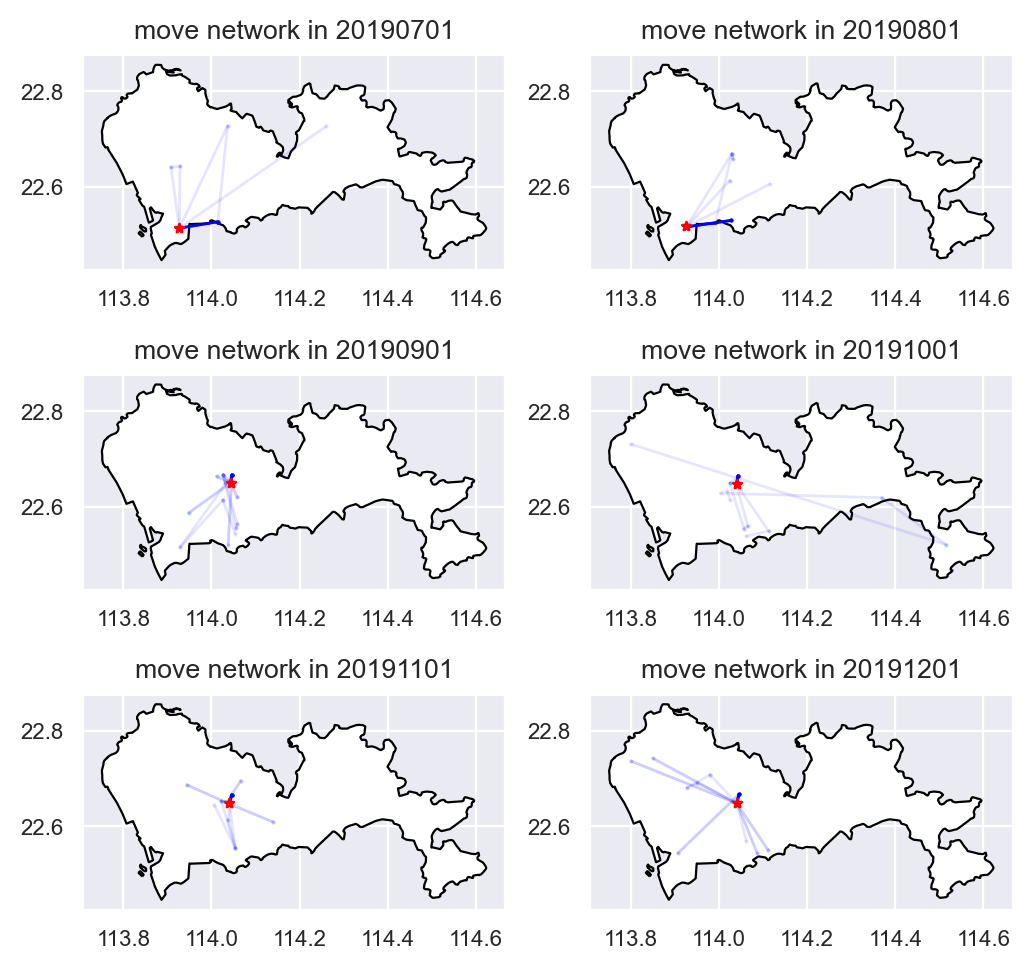

In [113]:
# 以分图的形式绘制每个月的出行网络
m = 3; n=2 #定义子图的行数和列数
fig,ax = plt.subplots(m,n,figsize= (6,6), dpi=200)
# 设置较小的字体
plt.rcParams.update({'font.size': 8})
for i in range(m):
    for j in range(n):
        t = i*n+j
        ax[i,j].set_title('move network in '+str(date_index[t]))
        move_data = sample_move_count[sample_move_count['yearmonth']==date_index[t]].reset_index(drop=True)
        home_data = sample_home_gpd[sample_home_gpd['date']==date_index[t]]

        sz_poly.plot(ax=ax[i,j],fc='white',ec='black',linewidth=.8)
        # 画出move_data，线的粗细由move_count决定
        for index in range(len(move_data)):
            x = [move_data['mean_lambda_o'][index],move_data['mean_lambda_d'][index]]
            y = [move_data['mean_phi_o'][index],move_data['mean_phi_d'][index]]
            # 透明度由stay_count决定
            alpha = (move_data['stay_count'][index]-min(move_data['stay_count']))/(max(move_data['stay_count'])-min(move_data['stay_count']))
            ax[i,j].plot(x,y, c = 'blue', marker = 'o', markersize=.5, linewidth=1, alpha=max(alpha,0.1))

        home_data.plot(ax=ax[i,j], c='red', marker='*', markersize=10,zorder=3)
    #ax.set_xlim(bounds[0],bounds[2])
    #ax.set_ylim(bounds[1],bounds[3])
plt.show()

## 迁居流可视化准备

In [30]:
# 导入深圳市区划的shp文件，并转化为geopandas的GeoDataFrame格式
sz_poly_county = gpd.read_file('D:/317研究组/4 居住自选择/data/深圳市2206/行政区划/区县级_深圳市行政区划.shp',encoding='utf-8')
sz_poly_county = sz_poly_county.to_crs(epsg=4326)
sz_poly_county

,name_prov,code_prov,name_city,code_city,name_coun,code_coun,geometry
0,广东省,440000,深圳市,440300,龙华区,440309,"POLYGON ((114.10825 22.72368, 114.10785 22.723..."
1,广东省,440000,深圳市,440300,宝安区,440306,"POLYGON ((113.81831 22.54676, 113.81816 22.546..."
2,广东省,440000,深圳市,440300,坪山区,440310,"POLYGON ((114.35085 22.76847, 114.35104 22.767..."
3,广东省,440000,深圳市,440300,南山区,440305,"POLYGON ((113.81491 22.39929, 113.80914 22.400..."
4,广东省,440000,深圳市,440300,南山区,440305,"POLYGON ((113.83951 22.51321, 113.83860 22.514..."
5,广东省,440000,深圳市,440300,福田区,440304,"POLYGON ((114.06118 22.58837, 114.06147 22.587..."
6,广东省,440000,深圳市,440300,光明区,440311,"POLYGON ((113.90608 22.83298, 113.90765 22.833..."
7,广东省,440000,深圳市,440300,宝安区,440306,"POLYGON ((113.74628 22.71824, 113.75723 22.739..."
8,广东省,440000,深圳市,440300,南山区,440305,"POLYGON ((113.83465 22.50151, 113.83429 22.502..."
9,广东省,440000,深圳市,440300,南山区,440305,"POLYGON ((114.01845 22.58444, 114.01826 22.584..."


<Axes: >

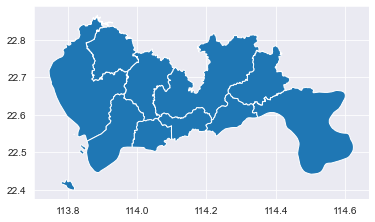

In [22]:
sz_poly_county.plot()

<Axes: >

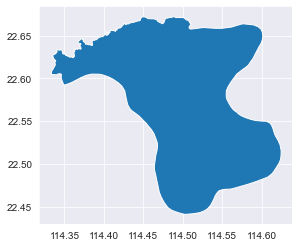

In [34]:
#sz_poly_county[sz_poly_county['name_coun']=='龙岗区']
# 修改龙岗区一部分为大鹏新区
sz_poly_county.loc[12,'name_coun'] = '大鹏新区'
sz_poly_county[sz_poly_county['name_coun']=='大鹏新区'].plot()

C:\Users\huangnx\AppData\Local\Temp\ipykernel_34276\2343727834.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: GEOGCS["CGCS_2000",DATUM["D_2000",SPHEROID["S_2000 ...

  sz_poly_county = gpd.clip(sz_poly_county,sz_poly)


<Axes: >

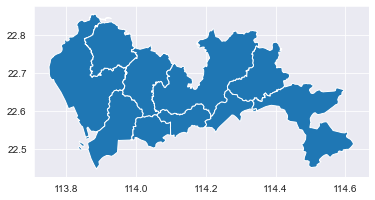

In [35]:
# 使用sz_poly裁剪sz_poly_county的每一行，即仅包含sz_poly内的区域
sz_poly_county = gpd.clip(sz_poly_county,sz_poly)
sz_poly_county.plot()

In [36]:
# 合并sz_poly_county中的同名区域
sz_poly_county = sz_poly_county.dissolve(by='name_coun').reset_index(drop=False)
sz_poly_county

,name_coun,geometry,name_prov,code_prov,name_city,code_city,code_coun
0,光明区,"POLYGON ((113.90955 22.83303, 113.90980 22.832...",广东省,440000,深圳市,440300,440311
1,南山区,"MULTIPOLYGON (((113.83585 22.50412, 113.83768 ...",广东省,440000,深圳市,440300,440305
2,坪山区,"POLYGON ((114.35089 22.76827, 114.35092 22.768...",广东省,440000,深圳市,440300,440310
3,大鹏新区,"POLYGON ((114.33450 22.62614, 114.33464 22.626...",广东省,440000,深圳市,440300,440307
4,宝安区,"MULTIPOLYGON (((113.78888 22.76607, 113.78859 ...",广东省,440000,深圳市,440300,440306
5,盐田区,"POLYGON ((114.22592 22.54880, 114.22532 22.549...",广东省,440000,深圳市,440300,440308
6,福田区,"POLYGON ((114.06147 22.58774, 114.06234 22.586...",广东省,440000,深圳市,440300,440304
7,罗湖区,"POLYGON ((114.09966 22.53772, 114.09964 22.537...",广东省,440000,深圳市,440300,440303
8,龙华区,"POLYGON ((114.10785 22.72343, 114.10732 22.722...",广东省,440000,深圳市,440300,440309
9,龙岗区,"POLYGON ((114.35048 22.76818, 114.34911 22.768...",广东省,440000,深圳市,440300,440307


In [47]:
# 导入迁居流数据
move_flow = pd.read_csv('D:/317研究组/4 居住自选择/data/space_change.csv')
move_flow.head()

,first_county,last_county,c
0,南山区,南山区,132274
1,南山区,坪山区,848
2,南山区,大鹏新区,158
3,南山区,宝安区,21205
4,南山区,盐田区,402


In [48]:
# 按照first_county分组，求每个区的迁居流比例
#total_move = move_flow.groupby('first_county')['c'].transform('sum')
total_move = move_flow.groupby('first_county').agg(sum_move= ('c','sum')).reset_index(drop=False)
move_flow = move_flow.merge(total_move,on='first_county',how='left')
move_flow['move_ratio'] = move_flow['c']/move_flow['sum_move']

In [49]:
# 根据move_flow的区名和sz_poly_county的name_coun关联数据，添加迁居流的起始区域和终止区域的geometry
move_flow = move_flow.merge(sz_poly_county[['name_coun','geometry']],left_on='first_county',right_on='name_coun',how='left')
move_flow.rename(columns={'geometry':'geometry_o'},inplace=True)
move_flow.drop(columns='name_coun',inplace=True)
move_flow = move_flow.merge(sz_poly_county[['name_coun','geometry']],left_on='last_county',right_on='name_coun',how='left')
move_flow.rename(columns={'geometry':'geometry_d'},inplace=True)
move_flow.drop(columns='name_coun',inplace=True)
move_flow.head()

,first_county,last_county,c,sum_move,move_ratio,geometry_o,geometry_d
0,南山区,南山区,132274,178469,0.741160,"MULTIPOLYGON (((113.83585 22.50412, 113.83768 ...","MULTIPOLYGON (((113.83585 22.50412, 113.83768 ..."
1,南山区,坪山区,848,178469,0.004752,"MULTIPOLYGON (((113.83585 22.50412, 113.83768 ...","POLYGON ((114.35089 22.76827, 114.35092 22.768..."
2,南山区,大鹏新区,158,178469,0.000885,"MULTIPOLYGON (((113.83585 22.50412, 113.83768 ...","POLYGON ((114.33450 22.62614, 114.33464 22.626..."
3,南山区,宝安区,21205,178469,0.118816,"MULTIPOLYGON (((113.83585 22.50412, 113.83768 ...","MULTIPOLYGON (((113.78888 22.76607, 113.78859 ..."
4,南山区,盐田区,402,178469,0.002252,"MULTIPOLYGON (((113.83585 22.50412, 113.83768 ...","POLYGON ((114.22592 22.54880, 114.22532 22.549..."


In [50]:
move_flow.to_csv('D:/317研究组/4 居住自选择/data/move_flow.csv',index=False)